<a href="https://colab.research.google.com/github/keval47/Machine-Learning/blob/master/deep%20neural%20network%20from%20scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from seaborn import heatmap
import time 

In [0]:
data = load_digits()
X = data.data
Y = data.target

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X,Y,random_state = 42)

y_train = y_train.reshape(len(y_train),1)
y_test = y_test.reshape(len(y_test),1)

In [0]:
class Neuron:
    def __init__(self,layers):

        self.w = []
        self.b = []
        self.output = []
        for i in (range(len(layers)-1)):
            print('layer',i,"->",layers[i],layers[i+1])
            self.w.append(np.random.random((layers[i],layers[i+1])))
            self.b.append(np.random.random((1,layers[i+1])))
            self.output.append(np.zeros((layers[i+1],1),dtype=np.float64))

In [0]:
class ffnn:
    def __init__(self):
        pass

    def layers(self,layers):
        self._neuron = Neuron(layers)# creating neurons
        self._nLayers = len(layers)
        self._lastl = len(layers)-2

    # function for matrix multiplication you can also use np.dot
    def _dot(self,a,b):
        matmul = []
        for val in a:
            valSum = 0
            for i in range(len(val)):
                valSum += val[i] * b[i]
            matmul.append(valSum)
        return np.array(matmul)

    def _OneHotEncoder(self,x):
        arr = np.zeros((len(x),np.max(x)+1),dtype=int)
        for i,val in enumerate(x):
            arr[i][val[0]] = 1
        return arr

    def _relu(self,z,deriv=False):
        if(deriv):
            return (z > 0) * 1.0
        return np.maximum(0,z)

    def _sigmoid(self,z,deriv=False):
        if(deriv):
            return z * (1-z)
        return 1/(1+(np.exp(-z)))

    def _softmax(self,x):
        xrel = x - x.max(axis=1, keepdims=True)# make every value 0 or below, as exp(0) won't overflow
        exp_xrel = np.exp(xrel)
        return exp_xrel / exp_xrel.sum(axis=1, keepdims=True) 
    
    # return weighted sum. return output based on weights
    def _feedforward(self):
        last = self._lastl
        weighted_sum0 = self._dot(self._x,self._neuron.w[0])+self._neuron.b[0]
        self._neuron.output[0] = self._relu(weighted_sum0)

        for i in range(1,self._nLayers-2):
            weighted_sum = self._dot(self._neuron.output[i-1],self._neuron.w[i])+self._neuron.b[i]
            self._neuron.output[i] = self._relu(weighted_sum)

        weighted_sum2 = self._dot(self._neuron.output[last-1],self._neuron.w[last])+self._neuron.b[self._lastl]
        self._neuron.output[last] = self._softmax(weighted_sum2)

    # perform backpropagation. adjusts weights that let us close to accurate output 
    def _backProp(self):
        last = self._lastl
        delta = []

        err0 = self._y - self._neuron.output[last] #calculate gradient of err. gradient=direction
        slope0 = self._relu(self._neuron.output[last],True) # calculate slope of output
        delta.append(err0 * slope0) #change in w_ho weights. define direction that make less error

        for i in range(self._nLayers-2):
            err = self._dot(delta[i],self._neuron.w[last-i].T)  
            slope = self._relu(self._neuron.output[last-(i+1)],True) 
            delta.append(err * slope) 

        self._neuron.w[0] += self._dot(self._x.T,delta[last]) * self._lr
        for i in range(1,self._nLayers-2):
            self._neuron.w[i] += self._dot(self._neuron.output[i-1].T,delta[last-i]) * self._lr

        for i in range(self._nLayers-2):
            self._neuron.b[i] += np.sum(delta[last-i],axis=0) * self._lr #step further to defined direction by delta. step = learning rate

    def _err(self):
        # mean squared err
        err = np.mean(np.square(self._y - self._neuron.output[self._lastl]),dtype=np.float64)
        return err

    def predict(self,x,prob=False):
        if(prob):
            res = np.zeros((np.shape(x)[0],np.shape(x)[1]))
        else:
            res = np.zeros((np.shape(x)[0],1),dtype=int)

        for i,val in enumerate(x):
            output = self._relu(self._dot([val],self._neuron.w[0])+self._neuron.b[0])
            for k in range(1,self._nLayers-2):
                output = self._relu(self._dot(output,self._neuron.w[k])+self._neuron.b[k])
            output = self._softmax(self._dot(output,self._neuron.w[self._lastl])+self._neuron.b[self._lastl])
            
            if(prob):
                res[i] = output
            else:
                res[i]= np.argmax(output)
        return res

    def hyper_params(self,lr=0.5,epochs=20,batch_size=32):
        self._lr = lr # learning rate
        self._epochs = epochs #iteration how many times data will be train
        self._batchSize = batch_size

    def fit(self,X,Y):
        self._x = X
        self._y = self._OneHotEncoder(Y)

    def _makeBatches(self):
        x = self._x
        y = self._y
        b = self._batchSize
        n_batchesDiv = int(x.shape[0] / b)
        batches = []
        for r in range(0,n_batchesDiv):
            # r = np.random.randint(0,n_batchesDiv)
            X = x[ (r*b) : ((r+1)*b) ]
            Y = y[ (r*b) : ((r+1)*b) ]
            batches.append([X,Y])
        return batches

    def train(self,printErr=False):
        t = time.time();
        batches = self._makeBatches()
        err = np.zeros((self._epochs,len(batches)))
        for i in range(self._epochs):
            for j,batch in enumerate(batches):
                self._x,self._y = batch
                self._feedforward()
                self._backProp()
                err[i][j] = self._err()
            if(printErr):
                print("epoch = %3d , err = %2.5f , Time = %2.3f" %(i+1,self._err(),time.time()-t))
            else:
                print("\r Epoch->",i+1,end="")
        return err

In [124]:
# running model
il = X_train.shape[1]
neuralnet = ffnn()
neuralnet.hyper_params(lr=0.01,epochs=20 ,batch_size=1)
neuralnet.layers([il,16,32,10])
neuralnet.fit(X_train,y_train)
err = neuralnet.train(True)

layer 0 -> 64 16
layer 1 -> 16 32
layer 2 -> 32 10
epoch =   1 , err = 0.09462 , Time = 1.152
epoch =   2 , err = 0.08839 , Time = 2.270
epoch =   3 , err = 0.07686 , Time = 3.378
epoch =   4 , err = 0.07432 , Time = 4.496
epoch =   5 , err = 0.05013 , Time = 5.601
epoch =   6 , err = 0.12099 , Time = 6.710
epoch =   7 , err = 0.07709 , Time = 7.815
epoch =   8 , err = 0.07016 , Time = 8.916
epoch =   9 , err = 0.03507 , Time = 10.035
epoch =  10 , err = 0.01449 , Time = 11.168
epoch =  11 , err = 0.00680 , Time = 12.281
epoch =  12 , err = 0.00306 , Time = 13.410
epoch =  13 , err = 0.00223 , Time = 14.562
epoch =  14 , err = 0.00163 , Time = 15.673
epoch =  15 , err = 0.00121 , Time = 16.800
epoch =  16 , err = 0.00096 , Time = 17.961
epoch =  17 , err = 0.00085 , Time = 19.117
epoch =  18 , err = 0.00077 , Time = 20.225
epoch =  19 , err = 0.00063 , Time = 21.365
epoch =  20 , err = 0.00059 , Time = 22.518


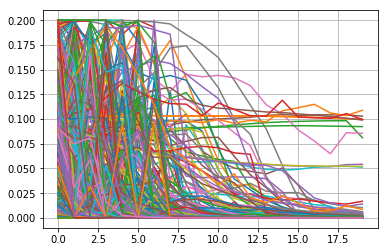

In [105]:
plt.plot(err)
plt.grid()
plt.show()

In [106]:
predictTrain = neuralnet.predict(X_train)
predictsTest = neuralnet.predict(X_test)
print("training acc = % 2.5f" %(accuracy_score(y_train,predictTrain)))
print("testing acc = % 2.5f" %(accuracy_score(y_test,predictsTest)))

training acc =  0.99406
testing acc =  0.94222


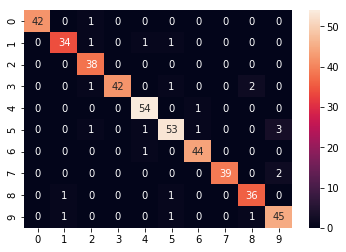

In [43]:
heatmap(confusion_matrix(y_test,predictsTest),annot=True)